# VCLOD Test for Coefficient 1

This script performs the main VCLOD test for this thesis with a specific diffusion coefficient. We investigate the energy error of the VCLOD dependent on the updated correctors. For this purpose, we update every corrector individually and compare it to the reference solution. This enables a good comparison between percentages. We desire to yield a fast decrease of the energy error of the VCLOD method since, due to the error indicator, we sort and update the element correctors in terms of the effect that comes with the perturbation.    

In [1]:
import os
import sys
import numpy as np
import scipy.sparse as sparse
import random
import csv

%matplotlib notebook
import matplotlib.pyplot as plt
from visualize import drawCoefficient
from data import * 

from gridlod import interp, coef, util, fem, world, linalg, femsolver
import pg_rand, femsolverCoarse, buildcoef2d
from gridlod.world import World

## Result function

The 'result' function investigates the VCLOD for each percentage. The reference solution is computed by a standard FEM on the fine mesh. We compute the 'worst solution' that represents zero percentage updating and clearly has no computational cost at all. Afterwards, we compute the error indicator for the given patch size $k=4$ and use every value gradually. Furthermore we store the resulting energy error for the VCLOD as well as the optimal energy error that results from 100 percentage updating. Once again, we take advantage of the 'gridlod' module in order to compute the required matrices.   

In [2]:
def result(pglod, world, A, R, f, k, String):
    print "-------------- " + String + " ---------------" 
    NWorldFine = world.NWorldFine
    NWorldCoarse = world.NWorldCoarse
    NCoarseElement = world.NCoarseElement
    
    boundaryConditions = world.boundaryConditions
    NpFine = np.prod(NWorldFine+1)
    NpCoarse = np.prod(NWorldCoarse+1)
        
    # new Coefficient
    ANew = R.flatten()
    Anew = coef.coefficientFine(NWorldCoarse, NCoarseElement, ANew)
    
    # reference solution
    f_fine = np.ones(NpFine)
    uFineFem, AFine, MFine = femsolver.solveFine(world, ANew, f_fine, None, boundaryConditions)
    
    # worst solution
    KFull = pglod.assembleMsStiffnessMatrix()
    MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
    free  = util.interiorpIndexMap(NWorldCoarse)                                 
    
    bFull = MFull*f
    KFree = KFull[free][:,free]
    bFree = bFull[free]

    xFree = sparse.linalg.spsolve(KFree, bFree)
    
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
    
    basisCorrectors = pglod.assembleBasisCorrectors()
    modifiedBasis = basis - basisCorrectors
    
    xFull = np.zeros(NpCoarse)
    xFull[free] = xFree
    uCoarse = xFull
    uLodFine = modifiedBasis*xFull
    
    uLodFineWorst = uLodFine
    
    # energy error
    errorworst = np.sqrt(np.dot(uFineFem - uLodFineWorst, AFine*(uFineFem - uLodFineWorst)))
    
    # tolerance = 0 
    vis, eps = pglod.updateCorrectors(Anew, 0, f, 1, clearFineQuantities=False, Computing=False)
    
    PotentialCorrectors = np.sum(vis)
    elemente = np.arange(np.prod(NWorldCoarse))
            
    # identify tolerances
    epsnozero = filter(lambda x: x!=0, eps)
    
    assert(np.size(epsnozero) != 0)
    
    mini = np.min(epsnozero)
    minilog = int(round(np.log10(mini)-0.49))
    epsnozero.append(10**(minilog))
    ToleranceListcomplete = []
    for i in range(0,int(np.size(epsnozero))):
        ToleranceListcomplete.append(epsnozero[i])

    ToleranceListcomplete.sort()
    ToleranceListcomplete = np.unique(ToleranceListcomplete)

    # with tolerance
    errorplotinfo = []
    tolerancesafe = []
    errorBest = []
    errorWorst = []
    recomputefractionsafe = []
    recomputefraction = 0
    Correctors = 0
    leng = np.size(ToleranceListcomplete)
    for k in range(leng-1,-1,-1):
        tol = ToleranceListcomplete[k]
        print " --- "+ str(-k+leng) + "/" + str(leng)+ " --- Tolerance: " + str(round(tol,5)) + " in "+ String +" ---- ", 
        vistol = pglod.updateCorrectors(Anew, tol, f, clearFineQuantities=False, Testing=True)
        
        Correctors += np.sum(vistol)
        
        recomputefraction += float(np.sum(vistol))/PotentialCorrectors * 100
        recomputefractionsafe.append(recomputefraction)
        
        KFull = pglod.assembleMsStiffnessMatrix()
        MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
        free  = util.interiorpIndexMap(NWorldCoarse)                                 

        bFull = MFull*f
        KFree = KFull[free][:,free]
        bFree = bFull[free]

        xFree = sparse.linalg.spsolve(KFree, bFree)
        basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)

        basisCorrectors = pglod.assembleBasisCorrectors()

        modifiedBasis = basis - basisCorrectors

        xFull = np.zeros(NpCoarse)
        xFull[free] = xFree
        uCoarse = xFull
        uLodFine = modifiedBasis*xFull
        
        #energy error
        errortol = np.sqrt(np.dot(uFineFem - uLodFine, AFine*(uFineFem - uLodFine)))
        
        errorplotinfo.append(errortol)
        tolerancesafe.append(tol)
    
    # 100% updating
    uLodFinebest = uLodFine
    errorbest = np.sqrt(np.dot(uFineFem - uLodFinebest, AFine*(uFineFem - uLodFinebest)))
    
    for k in range(leng-1,-1,-1):
        errorBest.append(errorbest)
        errorWorst.append(errorworst)

    return vis, eps, PotentialCorrectors, recomputefractionsafe, errorplotinfo, errorWorst, errorBest


## Preparations

We use the same setting as we have already used before containing the 'buildcoef2d' class in order to construct the coefficient. We visualize the coefficient and store the information in an extern folder.

<IPython.core.display.Javascript object>


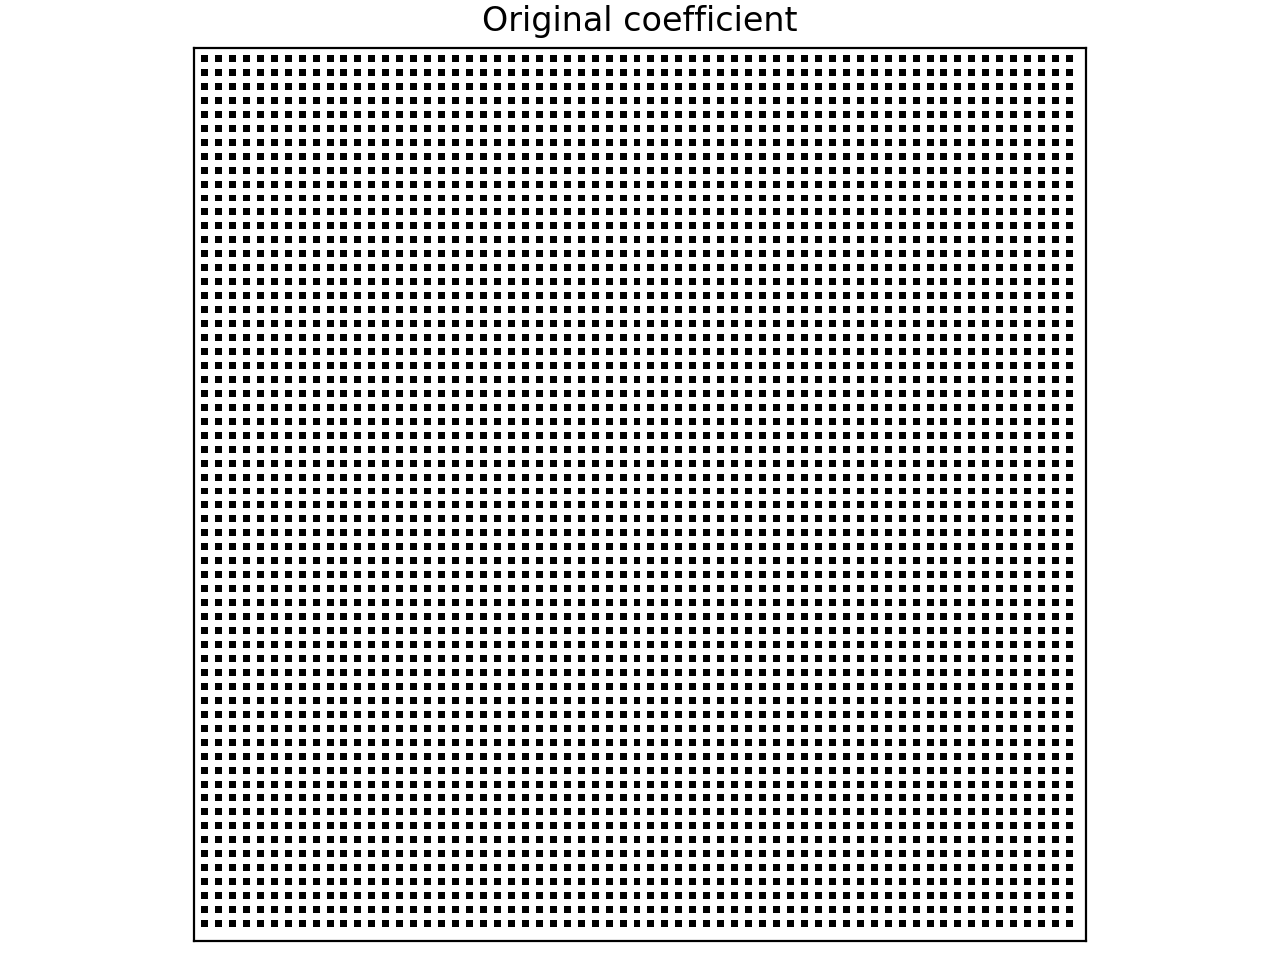

In [3]:
bg = 0.05       #background
val = 1         #values

#fine World
NWorldFine = np.array([256, 256])
NpFine = np.prod(NWorldFine+1)                                                                               

#coarse World
NWorldCoarse = np.array([16,16])
NpCoarse = np.prod(NWorldCoarse+1)

#ratio between Fine and Coarse
NCoarseElement = NWorldFine/NWorldCoarse

boundaryConditions = np.array([[0, 0],
                               [0, 0]])

world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

#righthandside
f = np.ones(NpCoarse)

#Coefficient 1
CoefClass = buildcoef2d.Coefficient2d(NWorldFine,
                        bg                  = bg,
                        val                 = val,
                        length              = 2,
                        thick               = 2,
                        space               = 2,
                        probfactor          = 1,
                        right               = 1,
                        down                = 0,
                        diagr1              = 0,
                        diagr2              = 0,
                        diagl1              = 0,
                        diagl2              = 0,
                        LenSwitch           = None,
                        thickSwitch         = None,
                        equidistant         = True,
                        ChannelHorizontal   = None,
                        ChannelVertical     = None,
                        BoundarySpace       = True)

A = CoefClass.BuildCoefficient()
ABase = A.flatten()

ROOT = '../test_data/Coef1/'

#safe NworldFine
with open("%s/NWorldFine.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in NWorldFine:
        writer.writerow([val])

#safe NworldCoarse
with open("%s/NWorldCoarse.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in NWorldCoarse:
        writer.writerow([val])

#ABase
with open("%s/OriginalCoeff.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in ABase:
        writer.writerow([val])

#fine-fem
f_fine = np.ones(NpFine)
uFineFem, AFine, MFine = femsolver.solveFine(world, ABase, f_fine, None, boundaryConditions)

#fine solution
with open("%s/finescale.txt" % ROOT, 'wb') as csvfile:
    writer = csv.writer(csvfile)
    for val in uFineFem:
        writer.writerow([val])
        
plt.figure("Original")
drawCoefficient(NWorldFine, ABase,greys=True)
plt.title("Original coefficient")
plt.show()

## Perturbations of the same entries

To keep comparability, we use the 'specific' perturbation function and use a random seed. 

In [4]:
# random seed
random.seed(20)

# decision
valc = np.shape(CoefClass.ShapeRemember)[0]
numbers = []
decision = np.zeros(100)
decision[0] = 1


for i in range(0,valc):
    a = random.sample(decision,1)[0]
    if a == 1:
        numbers.append(i)

value1 = 3
C1 = CoefClass.SpecificValueChange(ratio=value1,
                                    Number = numbers,
                                    probfactor=1,
                                    randomvalue=None,
                                    negative=None,
                                    ShapeRestriction=True,
                                    ShapeWave=None,
                                    ChangeRight=1,
                                    ChangeDown=1,
                                    ChangeDiagr1=1,
                                    ChangeDiagr2=1,
                                    ChangeDiagl1=1,
                                    ChangeDiagl2=1,
                                    Original = True,
                                    NewShapeChange = True)

V = CoefClass.SpecificVanish(Number = numbers,
                                probfactor=1,
                                PartlyVanish=None,
                                ChangeRight=1,
                                ChangeDown=1,
                                ChangeDiagr1=1,
                                ChangeDiagr2=1,
                                ChangeDiagl1=1,
                                ChangeDiagl2=1,
                                Original = True)

M1 = CoefClass.SpecificMove(probfactor=1,
                            Number = numbers,
                            steps=1,
                            randomstep=None,
                            randomDirection=None,
                            ChangeRight=1,
                            ChangeDown=1,
                            ChangeDiagr1=1,
                            ChangeDiagr2=1,
                            ChangeDiagl1=1,
                            ChangeDiagl2=1,
                            Right=1,
                            BottomRight=0,
                            Bottom=0,
                            BottomLeft=0,
                            Left=0,
                            TopLeft=0,
                            Top=0,
                            TopRight=0,
                            Original = True)

## Precomputations

In [ ]:
k = 4

NWorldFine = world.NWorldFine
NWorldCoarse = world.NWorldCoarse
NCoarseElement = world.NCoarseElement

boundaryConditions = world.boundaryConditions
NpFine = np.prod(NWorldFine+1)
NpCoarse = np.prod(NWorldCoarse+1)

#interpolant
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse, NCoarseElement, boundaryConditions)

#old Coefficient
ABase = A.flatten()
Aold = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase)

pglod = pg_rand.VcPetrovGalerkinLOD(Aold, world, k, IPatchGenerator, 0)
pglod.originCorrectors(clearFineQuantities=False)

We call the result function for each perturbation and store the result subsequently.

## Change in value

In [ ]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, C1, f, k, 'Specific value change' + str(value1))

safeChange(ROOT, C1, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

-------------- Specific value change3 ---------------
Not Recomputed!
 --- 1/257 --- Tolerance: 0.45442 in Specific value change3 ----  To be recomputed:  0.0 %
 --- 2/257 --- Tolerance: 0.44603 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 3/257 --- Tolerance: 0.43992 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 4/257 --- Tolerance: 0.43274 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 5/257 --- Tolerance: 0.42811 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 6/257 --- Tolerance: 0.4281 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 7/257 --- Tolerance: 0.42809 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 8/257 --- Tolerance: 0.42776 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 9/257 --- Tolerance: 0.41789 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 10/257 --- Tolerance: 0.41786 in Specific value change3 ----  To be

 --- 85/257 --- Tolerance: 0.00954 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 86/257 --- Tolerance: 0.00941 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 87/257 --- Tolerance: 0.00925 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 88/257 --- Tolerance: 0.00923 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 89/257 --- Tolerance: 0.00906 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 90/257 --- Tolerance: 0.00905 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 91/257 --- Tolerance: 0.00902 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 92/257 --- Tolerance: 0.00896 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 93/257 --- Tolerance: 0.00822 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 94/257 --- Tolerance: 0.00816 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 95/257 --- Tolerance: 0.0

 --- 170/257 --- Tolerance: 0.00351 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 171/257 --- Tolerance: 0.00346 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 172/257 --- Tolerance: 0.00327 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 173/257 --- Tolerance: 0.00318 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 174/257 --- Tolerance: 0.0029 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 175/257 --- Tolerance: 0.00267 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 176/257 --- Tolerance: 0.0026 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 177/257 --- Tolerance: 0.00224 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 178/257 --- Tolerance: 0.00198 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 179/257 --- Tolerance: 0.00194 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 180/257 --- Toler

 --- 254/257 --- Tolerance: 1e-05 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 255/257 --- Tolerance: 0.0 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 256/257 --- Tolerance: 0.0 in Specific value change3 ----  To be recomputed:  0.390625 %
 --- 257/257 --- Tolerance: 0.0 in Specific value change3 ----  To be recomputed:  0.390625 %


## Disappearance

In [ ]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, V, f, k, 'Vanish')

safeVanish(ROOT, V, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

-------------- Vanish ---------------
Not Recomputed!
 --- 1/257 --- Tolerance: 1.74144 in Vanish ----  To be recomputed:  0.0 %
 --- 2/257 --- Tolerance: 1.68025 in Vanish ----  To be recomputed:  0.390625 %
 --- 3/257 --- Tolerance: 1.65778 in Vanish ----  To be recomputed:  0.390625 %
 --- 4/257 --- Tolerance: 1.60702 in Vanish ----  To be recomputed:  0.390625 %
 --- 5/257 --- Tolerance: 1.57571 in Vanish ----  To be recomputed:  0.390625 %
 --- 6/257 --- Tolerance: 1.57566 in Vanish ----  To be recomputed:  0.390625 %
 --- 7/257 --- Tolerance: 1.57564 in Vanish ----  To be recomputed:  0.390625 %
 --- 8/257 --- Tolerance: 1.57416 in Vanish ----  To be recomputed:  0.390625 %
 --- 9/257 --- Tolerance: 1.52505 in Vanish ----  To be recomputed:  0.390625 %
 --- 10/257 --- Tolerance: 1.52491 in Vanish ----  To be recomputed:  0.390625 %
 --- 11/257 --- Tolerance: 1.5249 in Vanish ----  To be recomputed:  0.390625 %
 --- 12/257 --- Tolerance: 1.5249 in Vanish ----  To be recomputed:  0

 --- 102/257 --- Tolerance: 0.02059 in Vanish ----  To be recomputed:  0.390625 %
 --- 103/257 --- Tolerance: 0.02054 in Vanish ----  To be recomputed:  0.390625 %
 --- 104/257 --- Tolerance: 0.02023 in Vanish ----  To be recomputed:  0.390625 %
 --- 105/257 --- Tolerance: 0.02022 in Vanish ----  To be recomputed:  0.390625 %
 --- 106/257 --- Tolerance: 0.02021 in Vanish ----  To be recomputed:  0.390625 %
 --- 107/257 --- Tolerance: 0.02008 in Vanish ----  To be recomputed:  0.390625 %
 --- 108/257 --- Tolerance: 0.01991 in Vanish ----  To be recomputed:  0.390625 %
 --- 109/257 --- Tolerance: 0.01976 in Vanish ----  To be recomputed:  0.390625 %
 --- 110/257 --- Tolerance: 0.01976 in Vanish ----  To be recomputed:  0.390625 %
 --- 111/257 --- Tolerance: 0.01971 in Vanish ----  To be recomputed:  0.390625 %
 --- 112/257 --- Tolerance: 0.01968 in Vanish ----  To be recomputed:  0.390625 %
 --- 113/257 --- Tolerance: 0.01959 in Vanish ----  To be recomputed:  0.390625 %
 --- 114/257 ---

 --- 202/257 --- Tolerance: 0.00168 in Vanish ----  To be recomputed:  0.390625 %
 --- 203/257 --- Tolerance: 0.00141 in Vanish ----  To be recomputed:  0.390625 %
 --- 204/257 --- Tolerance: 0.00141 in Vanish ----  To be recomputed:  0.390625 %
 --- 205/257 --- Tolerance: 0.0012 in Vanish ----  To be recomputed:  0.390625 %
 --- 206/257 --- Tolerance: 0.00107 in Vanish ----  To be recomputed:  0.390625 %
 --- 207/257 --- Tolerance: 0.00106 in Vanish ----  To be recomputed:  0.390625 %
 --- 208/257 --- Tolerance: 0.00089 in Vanish ----  To be recomputed:  0.390625 %
 --- 209/257 --- Tolerance: 0.00083 in Vanish ----  To be recomputed:  0.390625 %
 --- 210/257 --- Tolerance: 0.00083 in Vanish ----  To be recomputed:  0.390625 %
 --- 211/257 --- Tolerance: 0.00082 in Vanish ----  To be recomputed:  0.390625 %
 --- 212/257 --- Tolerance: 0.00079 in Vanish ----  To be recomputed:  0.390625 %
 --- 213/257 --- Tolerance: 0.00079 in Vanish ----  To be recomputed:  0.390625 %
 --- 214/257 --- 

## Shift

In [ ]:
vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest = result(pglod ,world, A, M1, f, k, 'One Step Move')

safeShift(ROOT, M1, vis, eps, PotentialUpdated, recomputefractionsafe, errorplotinfo, errorworst, errorbest)

-------------- One Step Move ---------------
Not Recomputed!
 --- 1/257 --- Tolerance: 1.17346 in One Step Move ----  To be recomputed:  0.0 %
 --- 2/257 --- Tolerance: 1.1567 in One Step Move ----  To be recomputed:  0.390625 %
 --- 3/257 --- Tolerance: 1.14926 in One Step Move ----  To be recomputed:  0.390625 %
 --- 4/257 --- Tolerance: 1.13475 in One Step Move ----  To be recomputed:  0.390625 %
 --- 5/257 --- Tolerance: 1.1344 in One Step Move ----  To be recomputed:  0.390625 %
 --- 6/257 --- Tolerance: 1.10064 in One Step Move ----  To be recomputed:  0.390625 %
 --- 7/257 --- Tolerance: 1.10012 in One Step Move ----  To be recomputed:  0.390625 %
 --- 8/257 --- Tolerance: 1.10011 in One Step Move ----  To be recomputed:  0.390625 %
 --- 9/257 --- Tolerance: 1.1001 in One Step Move ----  To be recomputed:  0.390625 %
 --- 10/257 --- Tolerance: 1.0981 in One Step Move ----  To be recomputed:  0.390625 %
 --- 11/257 --- Tolerance: 1.06567 in One Step Move ----  To be recomputed:  

 --- 94/257 --- Tolerance: 0.04383 in One Step Move ----  To be recomputed:  0.390625 %
 --- 95/257 --- Tolerance: 0.04352 in One Step Move ----  To be recomputed:  0.390625 %
 --- 96/257 --- Tolerance: 0.04157 in One Step Move ----  To be recomputed:  0.390625 %
 --- 97/257 --- Tolerance: 0.04114 in One Step Move ----  To be recomputed:  0.390625 %
 --- 98/257 --- Tolerance: 0.04039 in One Step Move ----  To be recomputed:  0.390625 %
 --- 99/257 --- Tolerance: 0.04035 in One Step Move ----  To be recomputed:  0.390625 %
 --- 100/257 --- Tolerance: 0.04021 in One Step Move ----  To be recomputed:  0.390625 %
 --- 101/257 --- Tolerance: 0.04011 in One Step Move ----  To be recomputed:  0.390625 %
 --- 102/257 --- Tolerance: 0.03976 in One Step Move ----  To be recomputed:  0.390625 %
 --- 103/257 --- Tolerance: 0.03894 in One Step Move ----  To be recomputed:  0.390625 %
 --- 104/257 --- Tolerance: 0.03884 in One Step Move ----  To be recomputed:  0.390625 %
 --- 105/257 --- Tolerance:

 --- 187/257 --- Tolerance: 0.00551 in One Step Move ----  To be recomputed:  0.390625 %
 --- 188/257 --- Tolerance: 0.00518 in One Step Move ----  To be recomputed:  0.390625 %
 --- 189/257 --- Tolerance: 0.00514 in One Step Move ----  To be recomputed:  0.390625 %
 --- 190/257 --- Tolerance: 0.00505 in One Step Move ----  To be recomputed:  0.390625 %
 --- 191/257 --- Tolerance: 0.00472 in One Step Move ----  To be recomputed:  0.390625 %
 --- 192/257 --- Tolerance: 0.00461 in One Step Move ----  To be recomputed:  0.390625 %
 --- 193/257 --- Tolerance: 0.00427 in One Step Move ----  To be recomputed:  0.390625 %
 --- 194/257 --- Tolerance: 0.00427 in One Step Move ----  To be recomputed:  0.390625 %
 --- 195/257 --- Tolerance: 0.00417 in One Step Move ----  To be recomputed:  0.390625 %
 --- 196/257 --- Tolerance: 0.00385 in One Step Move ----  To be recomputed:  0.390625 %
 --- 197/257 --- Tolerance: 0.00335 in One Step Move ----  To be recomputed:  0.390625 %
 --- 198/257 --- Tole